# Tutorial 1: Human dorsolateral prefrontal cortex (10x Visium)
This tutorial demonstrates the analysis of a human Dorsolateral Prefrontal Cortex (DLPFC) dataset from 10x Visium. The data from Maynard et al. includes manual annotations of the cortical layers and white matter (WM), which were identified using morphological features and gene markers.

Dataset could be downloaded from [SpatialLIDB](https://github.com/LieberInstitute/spatialLIBD)

In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from cadast import CadaST
from cadast.utils import clustering

In [2]:
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (3, 3)

## Load the visium data and annotation files

In [3]:
dataset_path = "../dataset/DLPFC"  # Replace with the actual path to your dataset
section = "151673"
input_dir = os.path.join(dataset_path, section)
annotation = os.path.join(dataset_path, "annotation", section + "_truth.txt")
annotation = pd.read_csv(annotation, sep="\t", index_col=0, header=None)
adata = sc.read_visium(input_dir)
adata.var_names_make_unique()
adata.obs["truth"] = annotation

adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'truth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

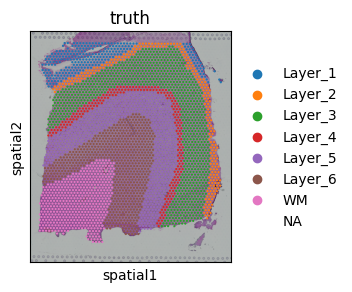

In [4]:
sc.pl.spatial(adata, color="truth")

## Preprocess the data

In [5]:
# Preprocess the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)

## Run CadaST
Including 3 steps:
1. Graph Construction 
2. Feature Selection
3. Iteratively predict and imputation

In [ ]:
alpha, theta  = 0.8, 0.2
icm_iter,max_iter = 2, 2
kneighbors = 16
n_top = 2000 # n_top SVG
n_jobs = 16 # parallel jobs 
model = CadaST(
    adata,
    kneighbors=kneighbors,
    icm_iter=icm_iter,
    max_iter=max_iter,
    alpha=alpha,
    theta=theta,
    n_top=n_top,
    n_jobs=n_jobs,
)
adata_fit = model.fit()
adata_fit 

Constructing Graph
Initializing neighbor correlation matrix
Initialized model with beta: 10, alpha: 0.8, theta: 0.2
Filtering genes with top 2000 SVG features
Start CadaST model fitting


100%|██████████| 2000/2000 [00:07<00:00, 259.41it/s]


AnnData object with n_obs × n_vars = 3639 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'truth'
    var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
    uns: 'spatial', 'truth_colors', 'log1p'
    obsm: 'spatial'
    layers: 'labels'

## Cluster with mclust and spatial domain visualization

In [7]:
clustering(adata=adata_fit, n_clusters=7, dims=8, refine=True)

Clustering using mclust


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



Refining the clustering results by majority voting


Adjusted rand index = 0.61


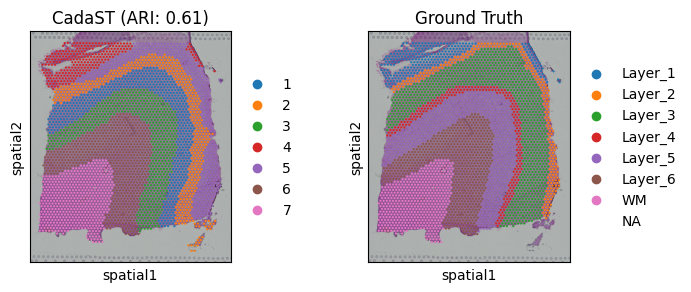

In [8]:
from sklearn.metrics.cluster import adjusted_rand_score
obs_df = adata_fit.obs.dropna()
ARI = adjusted_rand_score(obs_df['domain'], obs_df['truth'])
print('Adjusted rand index = %.2f' %ARI)

sc.pl.spatial(adata_fit, color=["domain", "truth"], title = [f"CadaST (ARI: {ARI:.2f})", "Ground Truth"])

## Plot the features' predicted states and the denoised expression

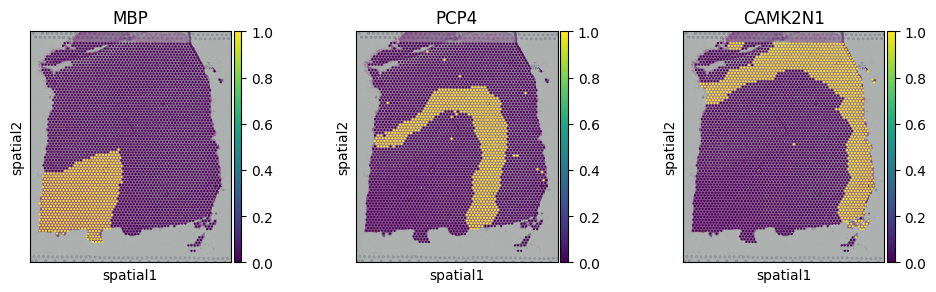

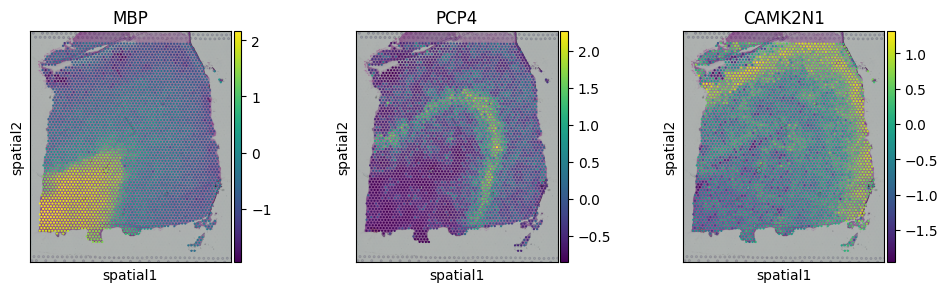

In [ ]:
# Plot the features' predicted states and the denoised expression
sc.pl.spatial(adata_fit, color=["MBP", "PCP4", "CAMK2N1"], layer="labels")
sc.pl.spatial(adata_fit, color=["MBP", "PCP4", "CAMK2N1"])